In [1]:
# import packages
%matplotlib inline
import geopandas as gp
import warnings
import numpy as np
import pandas as pd
from numpy import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

In [2]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from sklearn.cross_validation  import train_test_split

Using Theano backend.


## Data Wrangling

In [3]:
# read in data
internet = pd.read_csv('refined_data_6/predict.csv')
pumas = pd.read_csv('refined_data_6/puma50.csv')
blocks = pd.read_csv('refined_data_6/blocks50.csv')

In [4]:
# remove first column
pumas_cut = pumas.iloc[:, 1:]
blocks_cut = blocks.iloc[:, 1:]

In [5]:
# add in dependent variable
pumas_cut['internetP'] = internet['internetP']

In [6]:
# split into train and validate sets
train_df = pumas_cut.loc[pumas_cut['label'] == 'train']
val_df = pumas_cut.loc[pumas_cut['label'] == 'valid']
test_df = pumas_cut.loc[pumas_cut['label'] == 'test']

In [7]:
# drop label column
train_df = train_df.drop('label', 1)
val_df = val_df.drop('label', 1)
test_df = test_df.drop('label', 1)

In [8]:
# convert to float32
train_df = train_df.astype(np.float32)
train_norm = train_df.astype(np.float32)

val_df = val_df.astype(np.float32)
val_norm = val_df.astype(np.float32)

test_df = test_df.astype(np.float32)
test_norm = test_df.astype(np.float32)

blocks_df = blocks_cut.astype(np.float32)
blocks_norm = blocks_cut.astype(np.float32)

In [9]:
# take log
train_norm.iloc[:, :train_norm.shape[1]-1] = train_norm.iloc[:, :train_norm.shape[1]-1] + 1
train_norm.iloc[:, :train_norm.shape[1]-1] = np.log(train_norm.iloc[:, :train_norm.shape[1]-1])

val_norm.iloc[:, :val_norm.shape[1]-1] = val_norm.iloc[:, :val_norm.shape[1]-1] + 1
val_norm.iloc[:, :val_norm.shape[1]-1] = np.log(val_norm.iloc[:, :val_norm.shape[1]-1])

test_norm.iloc[:, :test_norm.shape[1]-1] = test_norm.iloc[:, :test_norm.shape[1]-1] + 1
test_norm.iloc[:, :test_norm.shape[1]-1] = np.log(test_norm.iloc[:, :test_norm.shape[1]-1])

blocks_norm = blocks_norm + 1
blocks_norm = np.log(blocks_norm)

## Normalization

In [10]:
# normalize data to heave mean = 0, std = 1
train_norm.iloc[:, :train_norm.shape[1]-1] = (train_norm.iloc[:, :train_norm.shape[1]-1] - train_norm.iloc[:, :train_norm.shape[1]-1].mean(axis=0)) / train_norm.iloc[:, :train_norm.shape[1]-1].std(axis=0, ddof=1)
val_norm.iloc[:, :val_norm.shape[1]-1] = (val_norm.iloc[:, :val_norm.shape[1]-1] - val_norm.iloc[:, :val_norm.shape[1]-1].mean(axis=0)) / val_norm.iloc[:, :val_norm.shape[1]-1].std(axis=0, ddof=1)
test_norm.iloc[:, :test_norm.shape[1]-1] = (test_norm.iloc[:, :test_norm.shape[1]-1] - test_norm.iloc[:, :test_norm.shape[1]-1].mean(axis=0)) / test_norm.iloc[:, :test_norm.shape[1]-1].std(axis=0, ddof=1)

blocks_norm = (blocks_norm - blocks_norm.mean(axis=0)) / blocks_norm.std(axis=0, ddof=1)

In [11]:
# replace NaN values with 0
train_norm = train_norm.fillna(0)
val_norm = val_norm.fillna(0)
test_norm = test_norm.fillna(0)

blocks_norm = blocks_norm.fillna(0)

In [12]:
# convert train and validate data to arrays
# assign feature (X) values
x_train = (train_norm.iloc[:, :train_norm.shape[1]-1]).values
x_val = (val_norm.iloc[:, :val_norm.shape[1]-1]).values
x_test = (test_norm.iloc[:, :test_norm.shape[1]-1]).values

# assign label (Y) values
y_train = (train_norm.iloc[:, train_norm.shape[1]-1:]).values

y_val = (val_norm.iloc[:, val_norm.shape[1]-1:]).values

y_test = (test_norm.iloc[:, test_norm.shape[1]-1:]).values

blocks_norm = blocks_norm.values

## Neural Network

In [13]:
model = Sequential()
model.add(Dense(output_dim=80, input_dim=np.shape(x_train)[1]))
model.add(Dropout(0.2))
model.add(Activation('tanh'))
model.add(Dense(output_dim=1))

model.compile(loss='mean_squared_error', optimizer='sgd')

In [14]:
history = model.fit(x_train, y_train, 
                    verbose=0, 
                    nb_epoch=2000, 
                    batch_size=500, 
                    show_accuracy=True, 
                    validation_data=(x_val, y_val))

In [15]:
score = model.evaluate(x_train, y_train, batch_size=2000)
print 'Training error %f' % (score)
print ''

score = model.evaluate(x_val, y_val, batch_size=2000)
print 'Validation error %f' % (score)
print ''

score = model.evaluate(x_test, y_test, batch_size=2000)
print 'Test error %f' % (score)

1521/1521 [==============================] - 0s
Training error 0.001283

381/381 [==============================] - 0s
Validation error 0.001910

476/476 [==============================] - 0s
Test error 0.002054


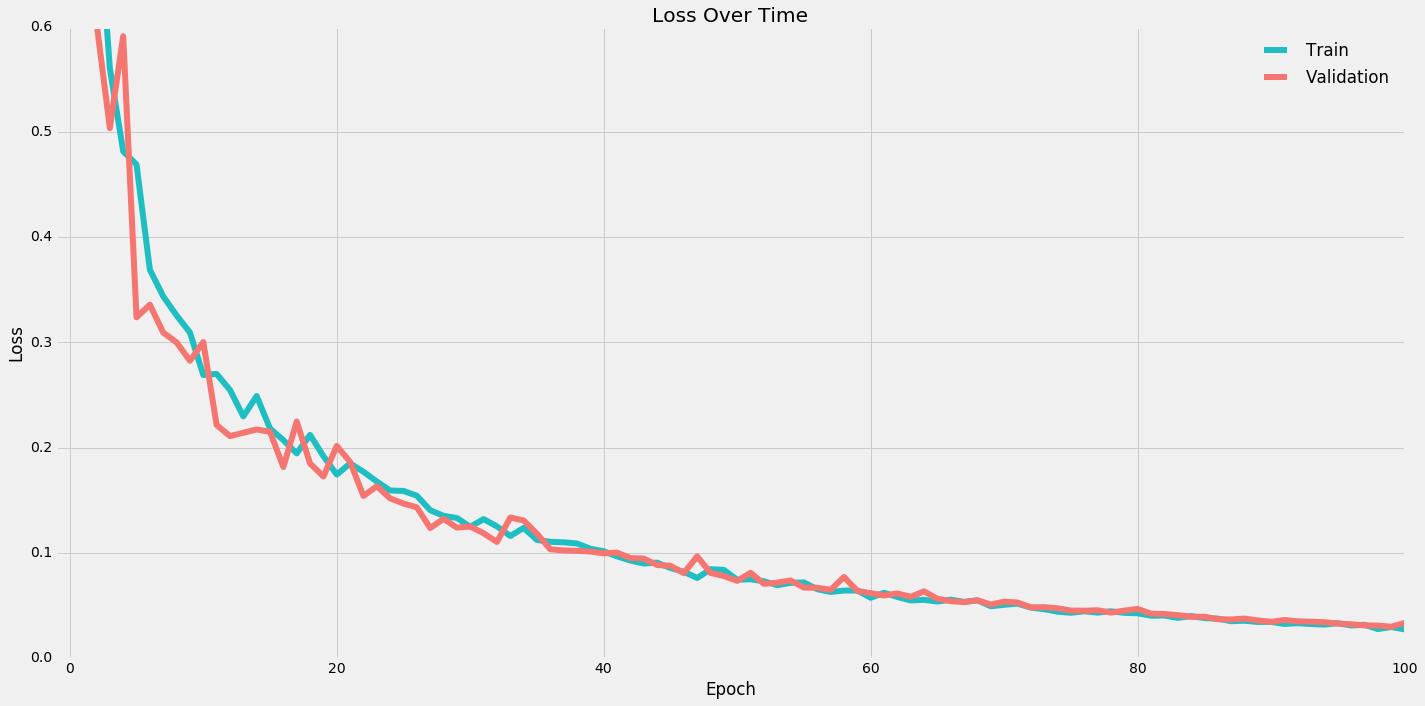

In [16]:
fig = plt.figure(figsize=(20,10))
plt.subplot(111)
plt.title('Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0,0.6])
plt.xlim([-1,100])
    
train = plt.plot(history.epoch, history.history['loss'], color='#1FBEC3', label='Train', linewidth=6)
val = plt.plot(history.epoch, history.history['val_loss'], color='#F57670', label='Validation', linewidth=6)
plt.legend(loc='upper right')

plt.tight_layout()

In [17]:
# predict based on validation features
y_pred_val = model.predict(x_val)

In [18]:
# predict based on test features
y_pred_test = model.predict(x_test)

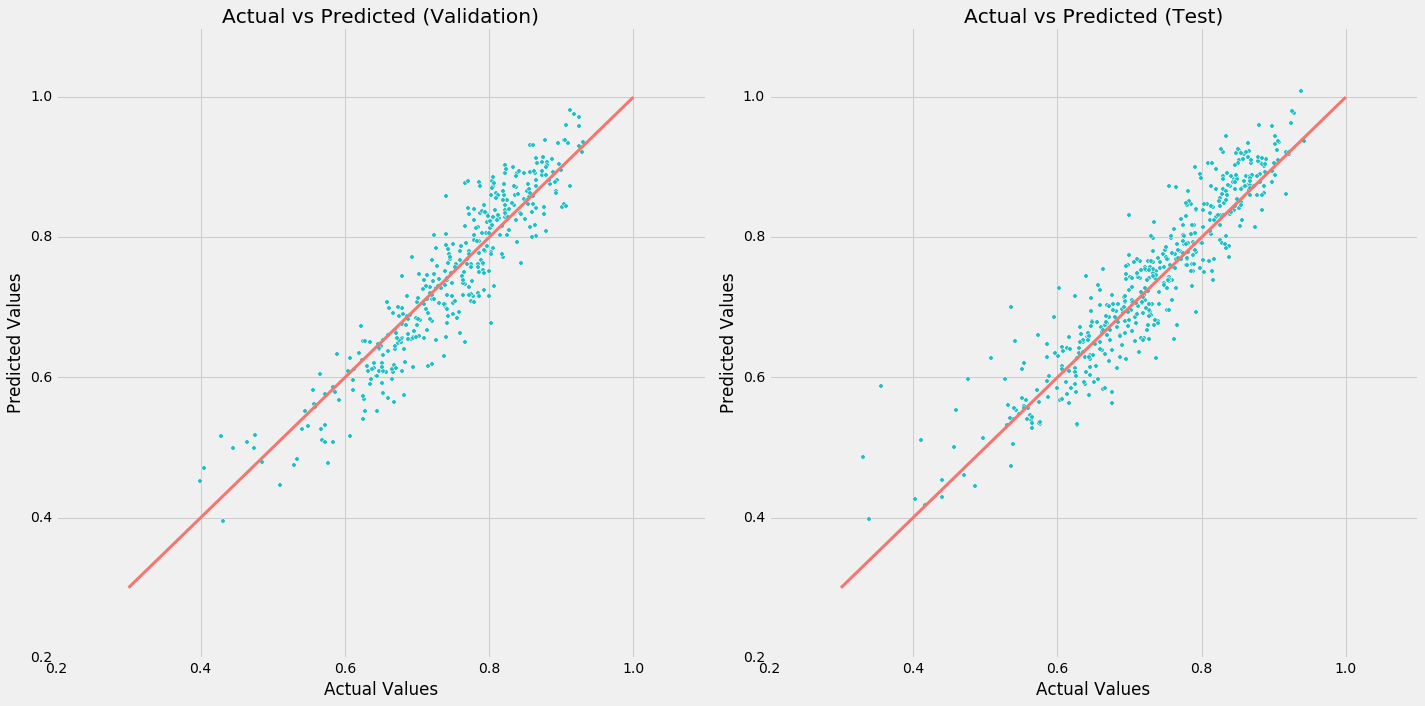

In [19]:
# plot predicted vs actual
fig = plt.figure(figsize=(20,10))
plt.subplot(121)
plt.scatter(y_val , y_pred_val, color='#1FBEC3', edgecolors='white')
plt.plot([0.3, 1], [0.3, 1], linewidth=3, color='#F57670')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted (Validation)')

# plot predicted vs actual
plt.subplot(122)
plt.scatter(y_test , y_pred_test, color='#1FBEC3', edgecolors='white')
plt.plot([0.3, 1], [0.3, 1], linewidth=3, color='#F57670')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted (Test)')

plt.tight_layout()

## Histograms

In [20]:
# predict based on block features
y_pred_blocks = model.predict(blocks_norm)

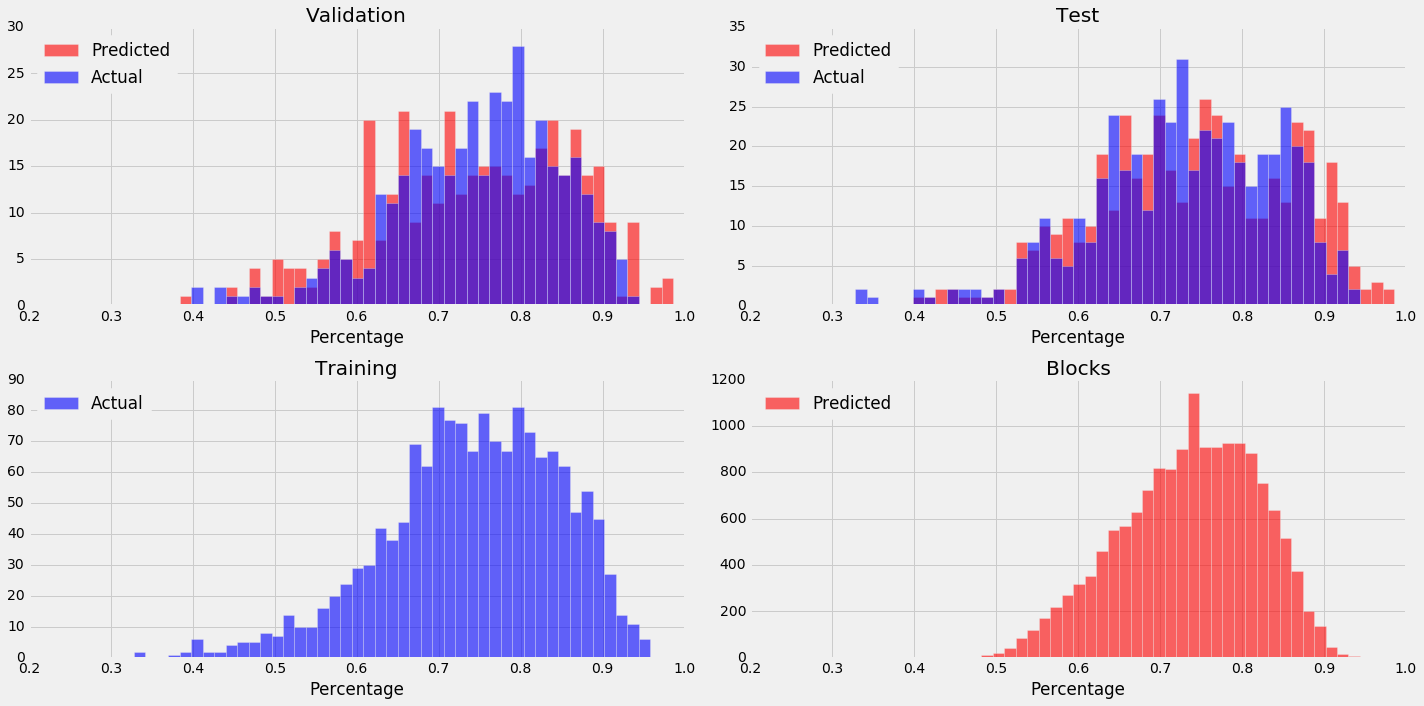

In [21]:
bins = 50
range = [0.3,1]
alpha = 0.6
fig = plt.figure(figsize=(20,10))

# TRAINING
plt.subplot(223)

plt.xlabel('Percentage')
plt.title("Training")

actual = y_train
plt.hist(actual, color='blue', bins=bins, alpha=alpha, range=range, label='Actual')
plt.legend(loc='upper left')

# VALIDATION
plt.subplot(221)

plt.title("Validation")
plt.xlabel('Percentage')

actual = y_val
prediction = y_pred_val
plt.hist(prediction, color='red', bins=bins, alpha=alpha, range=range, label='Predicted')
plt.hist(actual, color='blue',bins=bins,  alpha=alpha, range=range, label='Actual')
plt.legend(loc='upper left')

# TEST
plt.subplot(222)
plt.title("Test")
plt.xlabel('Percentage')

actual = y_test
prediction = y_pred_test
plt.hist(prediction, color='red', bins=bins, alpha=alpha, range=range, label='Predicted')
plt.hist(actual, color='blue', bins=bins, alpha=alpha,range=range, label='Actual')
plt.legend(loc='upper left')

# BLOCKS
plt.subplot(224)
plt.title("Blocks")
plt.xlabel('Percentage')

prediction = y_pred_blocks
plt.hist(prediction, color='red', bins=bins,alpha=alpha,range=range, label='Predicted')
plt.legend(loc='upper left')

plt.tight_layout()

## Save Model

In [23]:
json_string = model.to_json()
open('my_model_architecture.json', 'w').write(json_string)
model.save_weights('my_model_weights.h5', overwrite=True)